<a href="https://colab.research.google.com/github/Noznoc/access-classifier/blob/main/WIP_Exterior_Accessibility_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Binary Classifier of "Accessible" or "Inaccessible" Building Enterances
**Author:** Alex Lane and Julia Conzon <br>
**Date created:** 2021/03/18<br>
**Description:** Training an image classifier from scratch on the Mapillary API imagery collected on building enterances. This workflow follows the Classifier from [Scratch Keras tutorial](https://keras.io/examples/vision/image_classification_from_scratch/).

## Imports


Import the necessary Python packages for evaluation.

In [3]:
import sys # for importing directory
import tensorflow as tf # for modeling
from tensorflow import keras # for modeling
from keras.models import Sequential # following Wu et al. (2019) sequential model was used
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt # for visualizing images
# Display
from IPython.display import Image, display
import matplotlib.cm as c
import numpy as np
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

## Data Handling & Setup

### Load the data: "Accessible" and "Inaccessible" dataset

Compile data from the Mapillary API, [scripts accessible in another notebook]()

Confirm folder of Mapillary API imagery exists. Subfolders should be `Accessible` and `Inaccessible`, which each contain the images that represent the category.


In [ ]:
!ls OSM_And_Mapillary_Sequence_Dataset

import os, random
import shutil

# Function that randomly moves image files based on source directory, destination directory and number of files wanting to move
def randomly_move_imgs(src_dir, dst_dir, n):
  file_list = os.listdir(src_dir)
  for j in range(n):
    img = random.choice(file_list)
    shutil.move(src_dir + img, dst_dir)

# Read "OSM_And_Mapillary_Sequence_Dataset/Accessible" folder randomly select n and move to "Test/Accessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Accessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible"
# randomly_move_imgs(src_dir, dst_dir, n)

# Read "OSM_And_Mapillary_Sequence_Dataset/Inaccessible" folder and randomly select n and move to "Test/Inaccessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Inaccessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible"
# randomly_move_imgs(src_dir, dst_dir, n)

Model  Test  Train


### Preprocess Data


Steps includes standardizing the images to the same size (`image_size`). 

Keras `seed` command is an optional parameter to offer a random seed for shuffling and transforming the images to augment the dataset. 

In [ ]:
#image_size = (256,256)
image_size = (512, 512)
batch_size_custom = 8

# Randomly assign to a train dataset (85%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_custom,
    label_mode = 'binary',
)


# Randomly assign to a validation dataset (15%)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_custom,
    label_mode = 'binary',
    #shuffle = False,
)

# confirm classes
class_names = train_ds.class_names
print(class_names)

Found 824 files belonging to 2 classes.
Using 660 files for training.
Found 824 files belonging to 2 classes.
Using 164 files for validation.
['Accessible', 'Inaccessible']


### Preprocess and augment data alt method - WIP
Code is commented out while implementation is incomplete.

In [ ]:
'''
image_size = (512, 512)
batch_size_custom = 32

train_aug_gen = ImageDataGenerator(
    validation_split = 0.2, 
    horizontal_flip=True,
    brightness_range = [0.7,1.3],
    zoom_range = 0.2,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range=0.2,
    rotation_range=20, 
    )

train_ds_gen = train_aug_gen.flow_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_custom,
    classes = ['Accessible','Inaccessible'],
    class_mode = 'binary',
)

valid_ds_gen = train_aug_gen.flow_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_custom,
    classes = ['Accessible','Inaccessible'],
    class_mode = 'binary',
)
'''

### Data Augmentation

Considering the small sample for training, the dataset will be augmented, that is randomly flipped horizontally, rotated, contrasted and zoomed. Order impacts the image gets distorted. Different tests were applied to identify an optimal augmentation, as seen below:

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/


In [ ]:
data_augmentation = keras.Sequential(
    [
        # Reminder, the order in which transformations are called significantly 
        # affects the final augmentation.
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomTranslation(0.2,0.2),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.1),
        layers.experimental.preprocessing.RandomHeight(0.3),
        layers.experimental.preprocessing.RandomWidth(0.3),
        layers.experimental.preprocessing.Resizing(512, 512),
    ]
)

### Visualize Data

Label 1 is "inaccessible" and label 0 is "accessible".


InvalidArgumentError: ignored

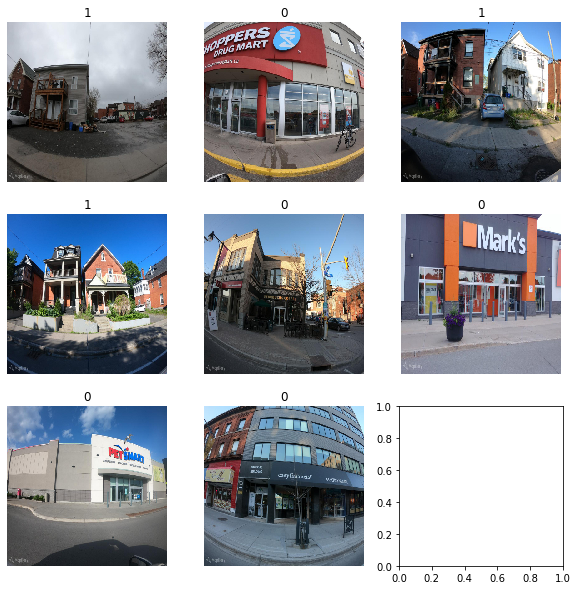

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Visualize Augmented Data


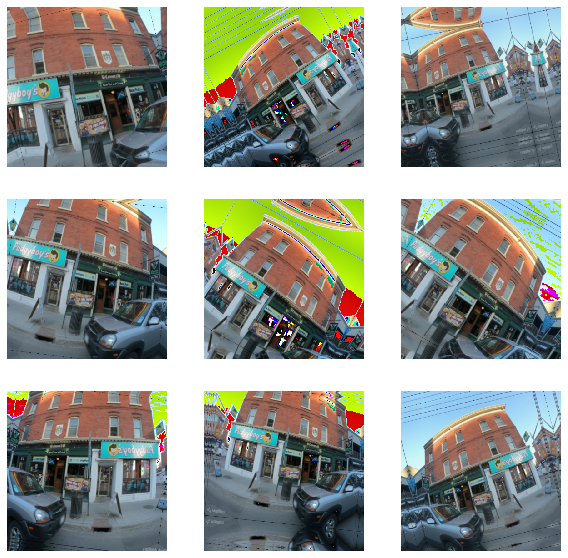

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Code is commented out while implementation is incomplete.
'''
plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(3, 3, i + 1)
	batch = train_ds_gen.next()
	image = batch[0].astype('uint8')
	plt.imshow(image[0])
plt.show()
'''

### Configure Dataset

Following documentation from Keras creator, François Chollet, use buffered prefetching to yield data from disk without having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)

#Build the Neural Network Model

## Build our *favoured* Model





Tensor("input_2_1:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("dense_3/Sigmoid_1:0", shape=(None, 1), dtype=float32)


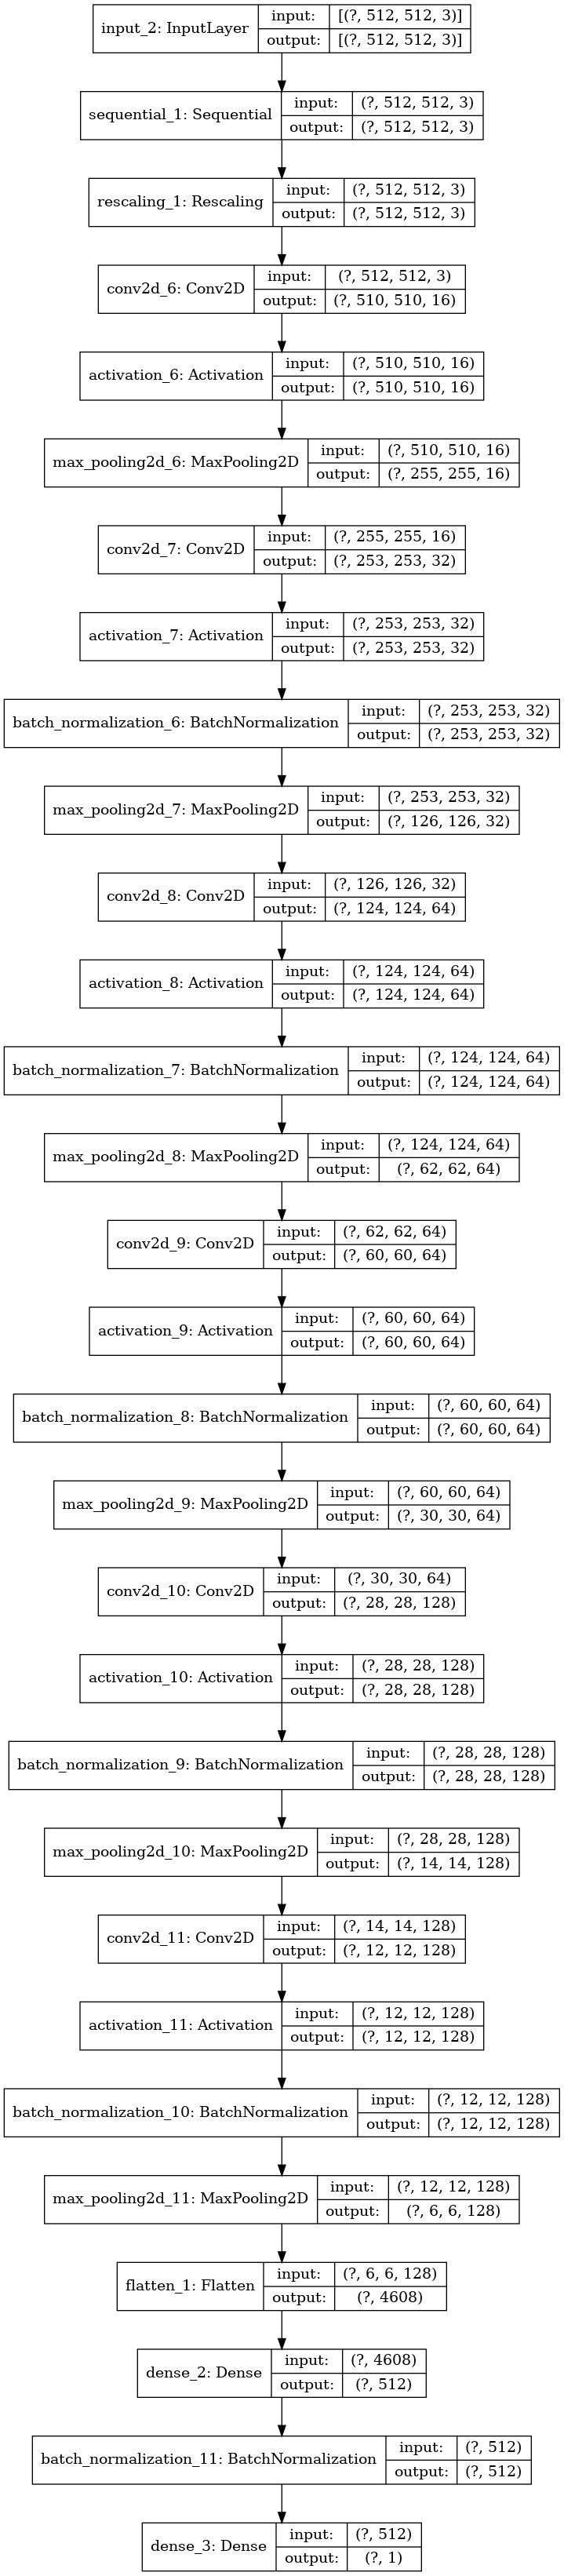

In [ ]:

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

## Build Grad-CAM (CNN6-CAM) Model

Tensor("input_1_1:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("dense_1/Sigmoid_1:0", shape=(None, 1), dtype=float32)


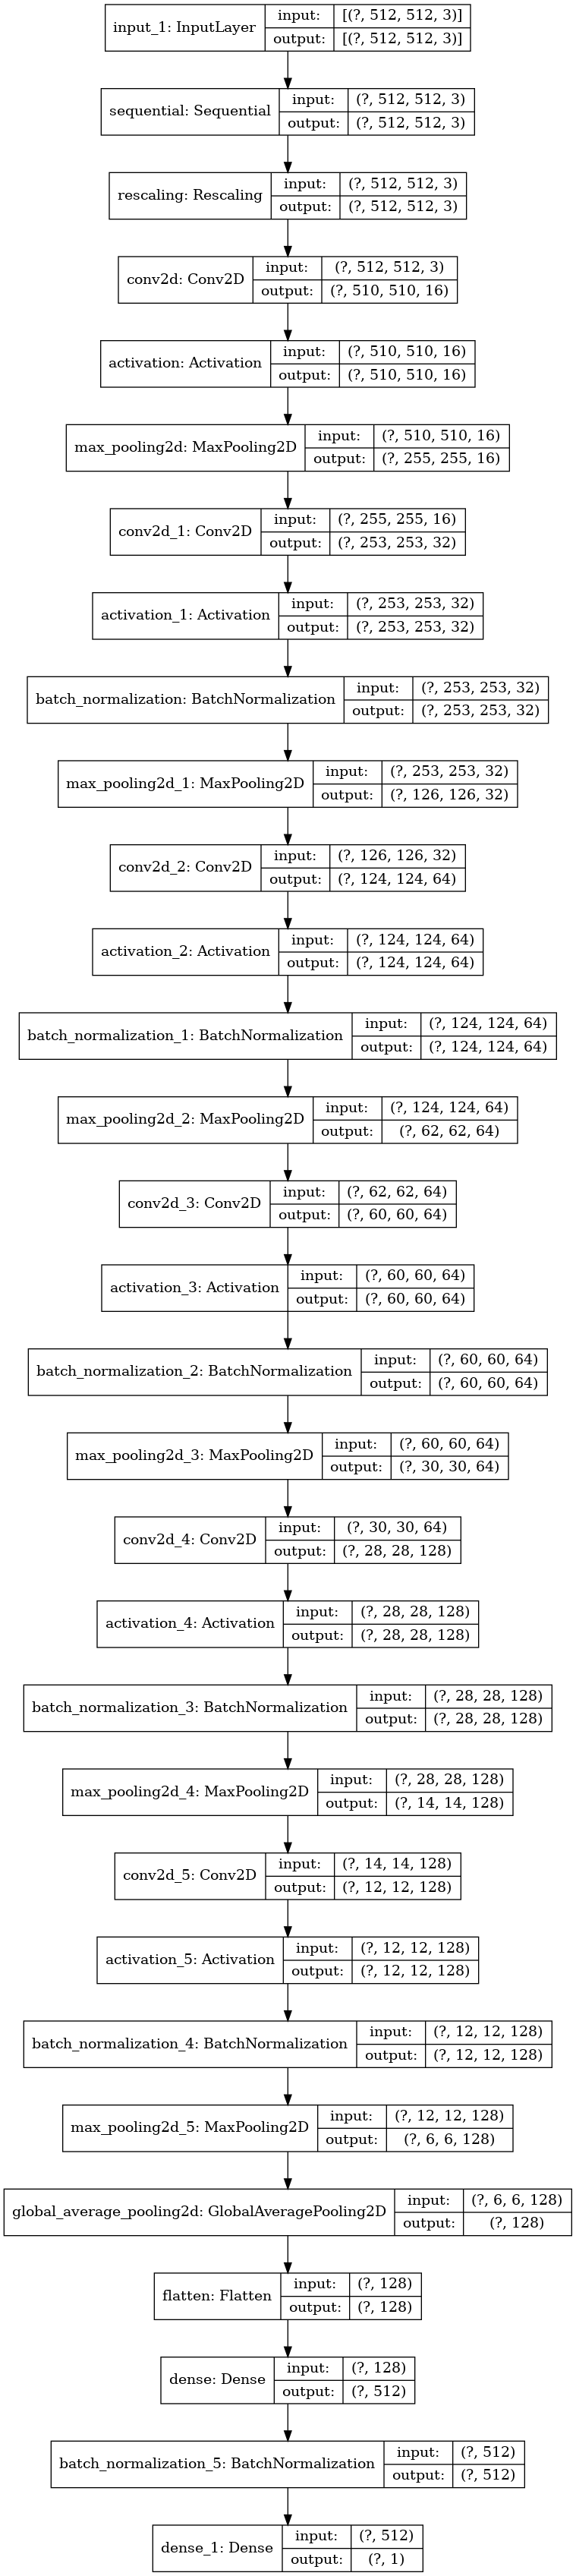

In [ ]:

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = GlobalAveragePooling2D()(layer) # for class activation mapping

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

## Build Alt. Model with more augmentations WIP
Code is commented out while implementation is incomplete.

Tensor("input_14:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("dense_27/Sigmoid:0", shape=(None, 1), dtype=float32)


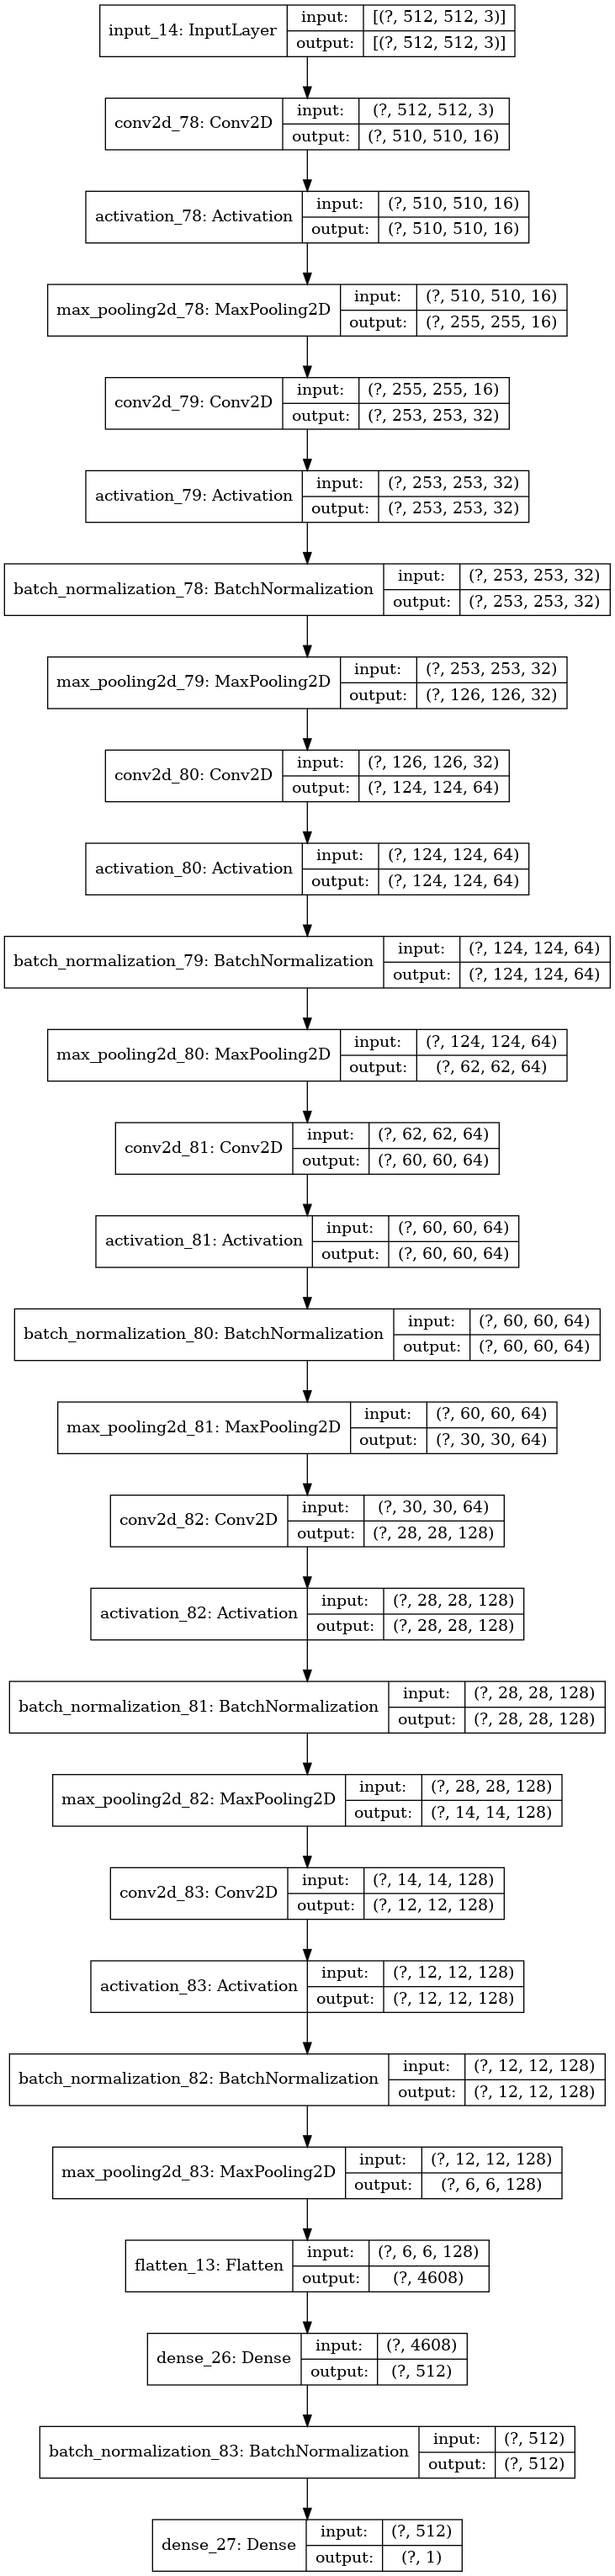

In [ ]:
'''
# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3)(inputs)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)
'''

## Build Heavily Modified "Wu et al. CNN5" Model - so modified it's basically not Wu CNN5
Start off with a simple Sequential model, following Wu et al. (2019)
Their CNNs require an inordinate amount of memory for med-high image size

In [ ]:
# MODEL ARCHITECTURES BY WU ET AL (2019):

# CNN2: CONV(64, 3), RELU, CONV(32, 3), RELU, POOL(2), CONV(64, 3), FC(128), RELU, FC(2), SOFTMAX.
# CNN3: [CONV(128, 3), RELU, POOL(2)], [CONV(64 3), RELU, POOL(2)], [CONV(32, 3), RELU, POOL(2)], DROPOUT(), RELU, FC(512), RELU, FC(2), SOFTMAX.
# CNN5: CONV(128, 3), RELU, CONV(128, 3), RELU, POOL(2), CONV(64, 3), DROPOUT(), RELU, CONV(64, 3), RELU, POOL(2), CONV(32, 3), DROPOUT(), RELU, POOL(2), FC(512), RELU, DROPOUT(), FC(256), RELU, FC(2), SOFTMAX

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
#layer = BatchNormalization()(layer)
#layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
#layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
#layer = Dropout(0.1)(layer)
layer = BatchNormalization(momentum=0.9)(layer)
#layer = Dense(256, activation='relu')(layer)
#layer = Dropout(0.1)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

## K-Fold Model - WIP
Code is commented out while implementation is incomplete.

https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#creating-a-keras-model-with-k-fold-cross-validation

In [ ]:
'''
kfold = KFold(n_splits=num_k_folds, shuffle=True)

fold_counter = 1
for train, test in kfold.split():

    # Model parameters
    input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
    num_classes = 2 # number of classes being defined

    # Initialize model
    inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
    print(inputs)
    layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

    # rescale the image to 1 and 0, not 255 RGB
    layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

    # Building blocks for CNN

    layer = Conv2D(filters=16, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=32, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=64, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=64, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=128, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=128, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Flatten()(layer)

    layer = Dense(512, activation='relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution
'''

# Training the Model & Metrics

## CNN6 Model Training & Plotting for Accuracy & Loss

Epoch 1/100
83/83 [==============================] - 26s 315ms/step - loss: 1.1167 - accuracy: 0.5894 - val_loss: 0.9197 - val_accuracy: 0.5549
Epoch 2/100
83/83 [==============================] - 27s 325ms/step - loss: 0.7735 - accuracy: 0.5970 - val_loss: 0.6728 - val_accuracy: 0.6707
Epoch 3/100
83/83 [==============================] - 27s 324ms/step - loss: 0.7456 - accuracy: 0.6121 - val_loss: 0.7462 - val_accuracy: 0.6463
Epoch 4/100
83/83 [==============================] - 28s 337ms/step - loss: 0.6216 - accuracy: 0.6818 - val_loss: 0.7316 - val_accuracy: 0.6707
Epoch 5/100
83/83 [==============================] - 28s 335ms/step - loss: 0.6250 - accuracy: 0.7045 - val_loss: 0.6329 - val_accuracy: 0.6829
Epoch 6/100
83/83 [==============================] - 27s 323ms/step - loss: 0.6249 - accuracy: 0.7045 - val_loss: 0.6698 - val_accuracy: 0.6768
Epoch 7/100
83/83 [==============================] - 28s 341ms/step - loss: 0.6525 - accuracy: 0.6576 - val_loss: 0.6476 - val_accuracy:

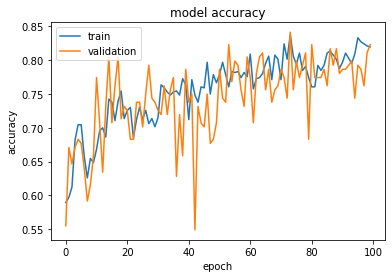

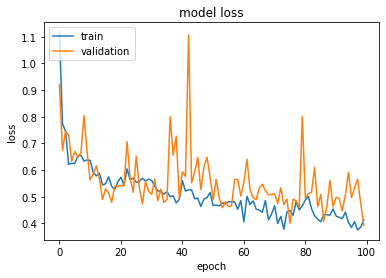

In [ ]:
# Number of epochs
epochs = 100

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("./OSM_And_Mapillary_Sequence_Data/Model/Epochs/100/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
             "accuracy",keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn')],
)

from keras.callbacks import CSVLogger

# TO INTEGRATE FOR LOGGING ACCURACY: 
csv_logger = CSVLogger('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/epochs_100_batch8_training.log', separator=',', append=False)
# https://stackoverflow.com/questions/47843265/how-can-i-get-the-a-keras-models-history-after-loading-it-from-a-file-in-python
classifier = model.fit(train_ds, epochs=epochs, callbacks=csv_logger, validation_data=valid_ds, shuffle=True)

# This following visualization is taken from 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### Alternative Accuracy & Loss Plotting

<ipython-input-39-f086400cef6b>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


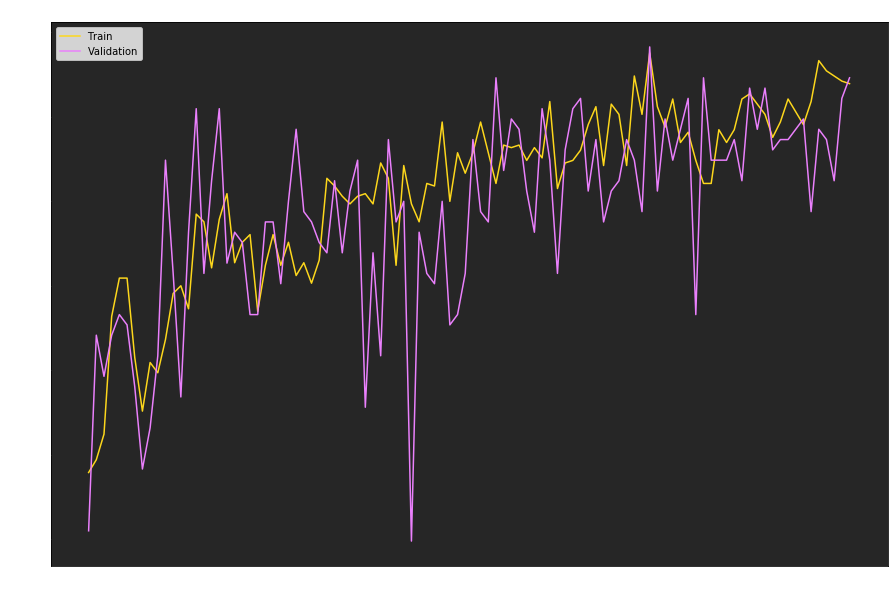

<ipython-input-39-f086400cef6b>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


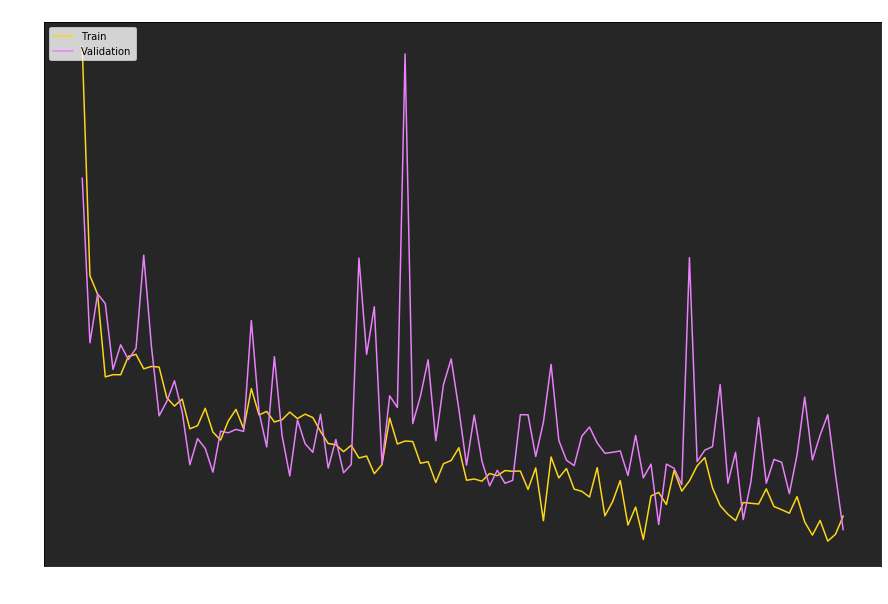

In [ ]:
plt.plot(classifier.history['accuracy'], color='#fdd71c', markerfacecolor='blue')
plt.plot(classifier.history['val_accuracy'], color='#EA80FC',  markerfacecolor='blue')
plt.title('Model Accuracy', color="white")
plt.ylabel('Accuracy', color="white")
plt.xlabel('Epoch', color="white")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis(color="white")
ax = plt.axes()
ax.tick_params(colors='white')
ax.set_facecolor("#262626ff")
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'], color='#fdd71c')
plt.plot(classifier.history['val_loss'], color='#EA80FC')
plt.title('Model Loss', color="white")
plt.ylabel('Loss', color="white")
plt.xlabel('Epoch', color="white")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.rcParams['figure.figsize'] = [15, 10]
ax = plt.axes()
ax.tick_params(colors='white')
ax.set_facecolor("#262626ff")
plt.show()

### Evaluate & Output Metrics

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
             "accuracy",keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn')],
)
model.evaluate(valid_ds)

21/21 [==============================] - 3s 158ms/step - loss: 0.3925 - accuracy: 0.8232 - tp: 76.0000 - fp: 16.0000 - tn: 59.0000 - fn: 13.0000


[0.39251378178596497, 0.8231707215309143, 76.0, 16.0, 59.0, 13.0]

## Training for "Our Model, but with more augmentations" - WIP
Code is commented out while implementation is incomplete.

In [ ]:
'''
# Number of epochs
epochs = 50

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("OSM_And_Mapillary_Sequence_Data/Model/Epochs/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

classifier = model.fit(
    train_ds_gen, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=valid_ds_gen, 
    shuffle=True,
    steps_per_epoch = 660//batch_size_custom,
    validation_steps = 164//batch_size_custom,
    )

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
             "accuracy",keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn')],
)
model.evaluate(valid_ds)

# This following visualization is taken from 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
'''

## CNN6-CAM Model Training

Epoch 1/100
83/83 [==============================] - 28s 337ms/step - loss: 0.8394 - accuracy: 0.5864 - tp: 180.0000 - fp: 129.0000 - tn: 207.0000 - fn: 144.0000 - val_loss: 1.3169 - val_accuracy: 0.4573 - val_tp: 52.0000 - val_fp: 52.0000 - val_tn: 23.0000 - val_fn: 37.0000
Epoch 2/100
83/83 [==============================] - 27s 327ms/step - loss: 0.6598 - accuracy: 0.6530 - tp: 208.0000 - fp: 113.0000 - tn: 223.0000 - fn: 116.0000 - val_loss: 0.9348 - val_accuracy: 0.5793 - val_tp: 26.0000 - val_fp: 6.0000 - val_tn: 69.0000 - val_fn: 63.0000
Epoch 3/100
83/83 [==============================] - 27s 322ms/step - loss: 0.6523 - accuracy: 0.6576 - tp: 198.0000 - fp: 100.0000 - tn: 236.0000 - fn: 126.0000 - val_loss: 1.0898 - val_accuracy: 0.4817 - val_tp: 34.0000 - val_fp: 30.0000 - val_tn: 45.0000 - val_fn: 55.0000
Epoch 4/100
83/83 [==============================] - 26s 313ms/step - loss: 0.6255 - accuracy: 0.6682 - tp: 211.0000 - fp: 106.0000 - tn: 230.0000 - fn: 113.0000 - val_loss:

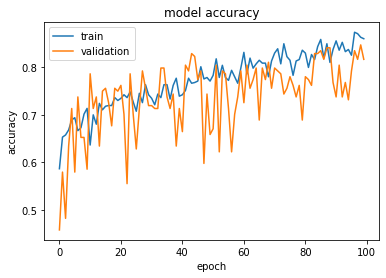

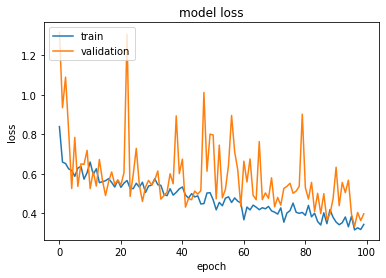

In [ ]:
# Number of epochs
epochs = 100

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("./OSM_And_Mapillary_Sequence_Data/Model/Epochs/100/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
             "accuracy",keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn')],
)

from keras.callbacks import CSVLogger

# TO INTEGRATE FOR LOGGING ACCURACY: 
csv_logger = CSVLogger('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/epochs_100_batch8_training_poolAv.log', separator=',', append=False)
# https://stackoverflow.com/questions/47843265/how-can-i-get-the-a-keras-models-history-after-loading-it-from-a-file-in-python
classifier = model.fit(train_ds, epochs=epochs, callbacks=csv_logger, validation_data=valid_ds, shuffle=True)

# This following visualization is taken from 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# Save Model

In [ ]:
model.save('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/100 Epoch GlobalAvPooling/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/100 Epoch GlobalAvPooling/assets


# Load Model

Alternatively, load a model instead of training a new one

In [11]:
#model = keras.models.load_model('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/100 Epoch 80-20 Overfit w 82-82 batch 8 & norm/')
model = keras.models.load_model('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/100 Epoch GlobalAvPooling/')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 510, 510, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)     

# Create Class Activation Map with CNN6-CAM

Followed [Keras tutorial](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/grad_cam.ipynb#scrollTo=Acnzf_vJ2FRo)

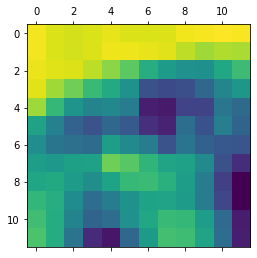

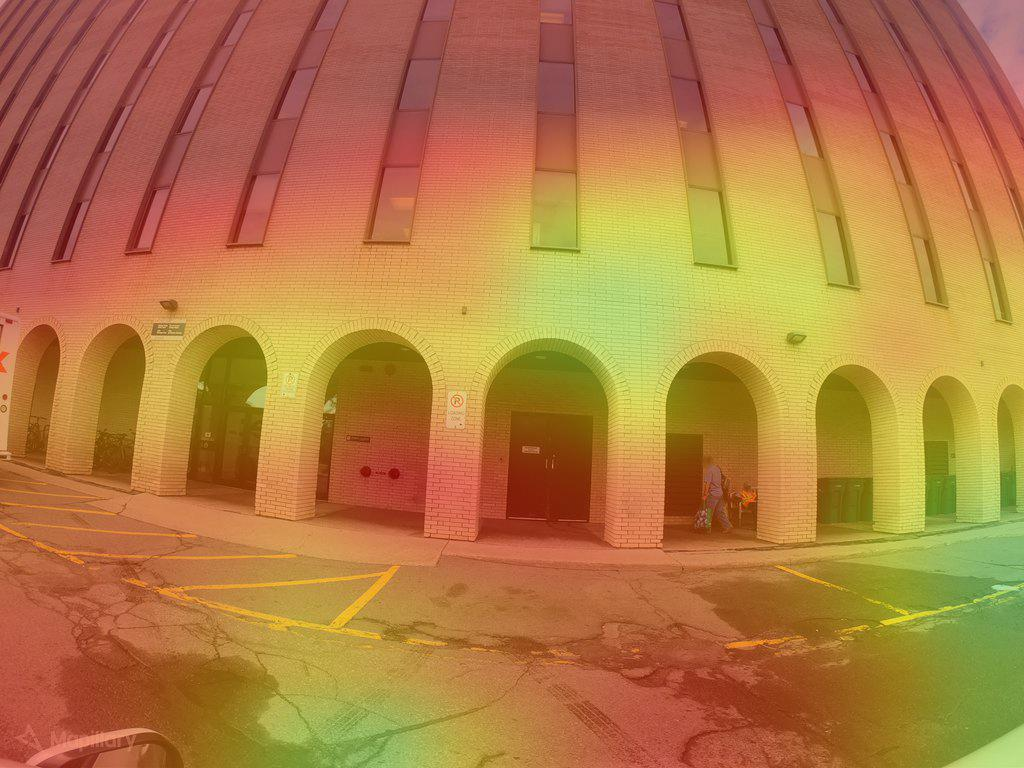

In [26]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) 
    return heatmap.numpy()

model_builder = keras.applications.xception.Xception

last_conv_layer_name = "conv2d_5"

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Prepare image
directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/Billings Bridge Shopping Centre 2277 Riverside Drive 63.png'
img_array = preprocess_input(get_img_array(directory, size=image_size))

# Remove last layer's sigmoid
model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.9):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

save_and_display_gradcam(directory, heatmap)

# Test Model


## Test CNN6 Model

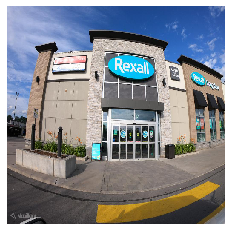

Staples 1595 Merivale Road 75.png
This image of building entrance is 98.22 percent accessible and 1.78 percent inaccessible.
✅ - This image has been correctly classified as accessible.



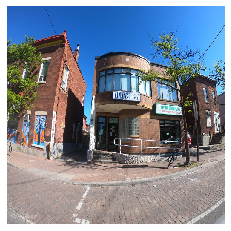

0245 -Q2FqoePMq5qkC4FM_IU6Q.png
This image of building entrance is 1.95 percent accessible and 98.05 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



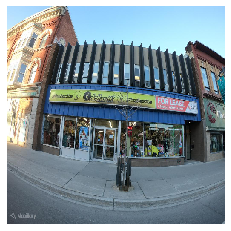

0566 QR6cBiunpB_PXCisWczWPw.png
This image of building entrance is 99.37 percent accessible and 0.63 percent inaccessible.
✅ - This image has been correctly classified as accessible.



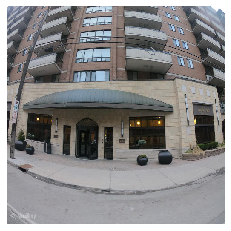

Albert at Bay Suite Hotel 435 Albert Street 0.png
This image of building entrance is 94.82 percent accessible and 5.18 percent inaccessible.
✅ - This image has been correctly classified as accessible.



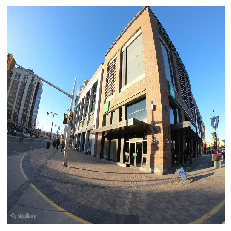

0009 A8-IT0RqrOz9YlybO7_UEg.png
This image of building entrance is 99.54 percent accessible and 0.46 percent inaccessible.
✅ - This image has been correctly classified as accessible.



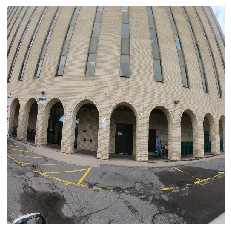

Billings Bridge Shopping Centre 2277 Riverside Drive 63.png
This image of building entrance is 31.44 percent accessible and 68.56 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



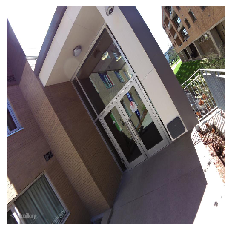

Glengarry House 1125 Colonel By Drive 37.png
This image of building entrance is 72.69 percent accessible and 27.31 percent inaccessible.
✅ - This image has been correctly classified as accessible.



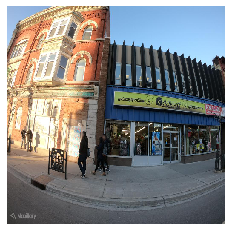

0568 5gjKjaLu72fZulzYn6dakA.png
This image of building entrance is 99.71 percent accessible and 0.29 percent inaccessible.
✅ - This image has been correctly classified as accessible.



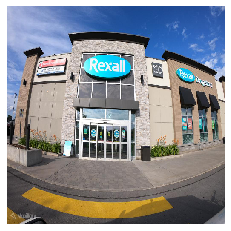

Staples 1595 Merivale Road 68.png
This image of building entrance is 98.40 percent accessible and 1.60 percent inaccessible.
✅ - This image has been correctly classified as accessible.



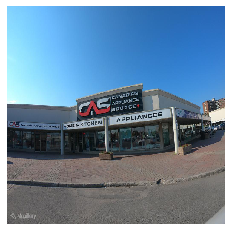

Ottawa Public Library - Emerald Plaza Branch 1547 Merivale Road 4.png
This image of building entrance is 95.20 percent accessible and 4.80 percent inaccessible.
✅ - This image has been correctly classified as accessible.



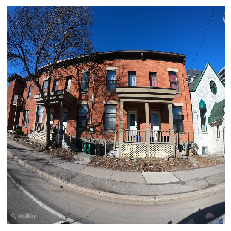

Meta Esthétique 250 A Lyon Street North 3.png
This image of building entrance is 7.99 percent accessible and 92.01 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



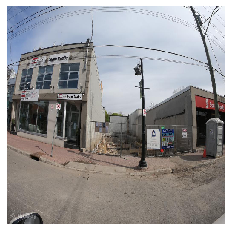

Scotiabank 388 Richmond Road 11.png
This image of building entrance is 59.93 percent accessible and 40.07 percent inaccessible.
❌ - This image has been incorrectly classified as accessible.



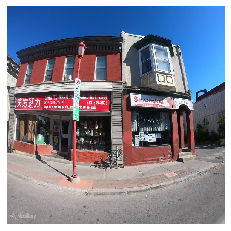

0096 olMK38JhuePHS_vVPQrYkw.png
This image of building entrance is 0.23 percent accessible and 99.77 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



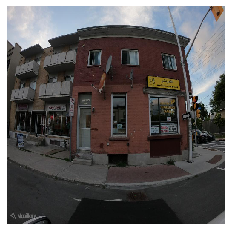

0077 X8w1Xk4VrfMbOqCxztCi3w.png
This image of building entrance is 4.83 percent accessible and 95.17 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



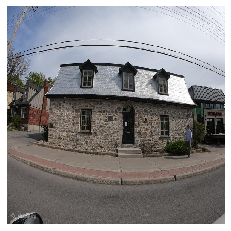

0042 kgZ8UZmcHMX6iYWQb05jcA.png
This image of building entrance is 28.82 percent accessible and 71.18 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



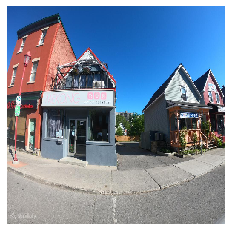

0087 xqF3ROA1jI2Z-7cSkyLxCQ.png
This image of building entrance is 1.28 percent accessible and 98.72 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



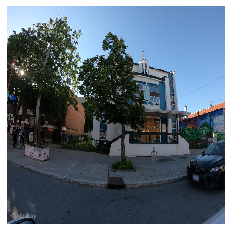

725 Somerset Street West 10.png
This image of building entrance is 15.75 percent accessible and 84.25 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



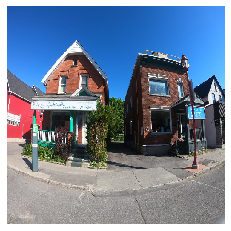

Jadeland Restaurant 625 Somerset Street West 0.png
This image of building entrance is 0.58 percent accessible and 99.42 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



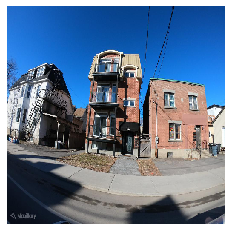

474 Lyon Street North 2.png
This image of building entrance is 0.57 percent accessible and 99.43 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



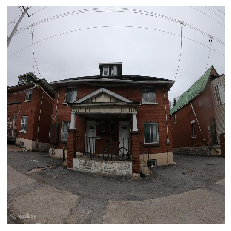

465 Catherine Street 13.png
This image of building entrance is 1.91 percent accessible and 98.09 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.

8 of the 10 accessible images were correctly classified as accessible.
9 of the 10 inaccessible images were correctly classified as inaccessible.


In [ ]:
import os

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/'
correctInaccessible = 0
correctAccessible = 0

for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage),target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score < 0.5):
            print("✅ - This image has been correctly classified as accessible.\n")
            correctAccessible += 1
        elif (score== 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as inaccessible.\n")

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible/'
for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage), 
                                                 target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score > 0.5):
            print("✅ - This image has been correctly classified as inaccessible.\n")
            correctInaccessible += 1
        elif (score == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as accessible.\n")

print("%i of the 10 accessible images were correctly classified as accessible." % correctAccessible)
print("%i of the 10 inaccessible images were correctly classified as inaccessible." % correctInaccessible)


## Test CNN6-CAM Model

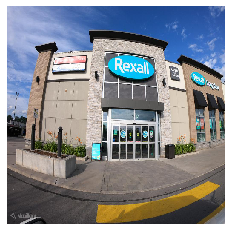

Staples 1595 Merivale Road 75.png
This image of building entrance is 99.62 percent accessible and 0.38 percent inaccessible.
✅ - This image has been correctly classified as accessible.



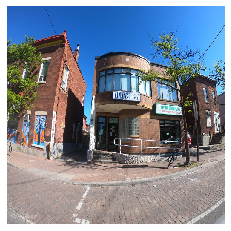

0245 -Q2FqoePMq5qkC4FM_IU6Q.png
This image of building entrance is 9.48 percent accessible and 90.52 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



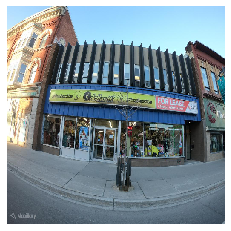

0566 QR6cBiunpB_PXCisWczWPw.png
This image of building entrance is 97.81 percent accessible and 2.19 percent inaccessible.
✅ - This image has been correctly classified as accessible.



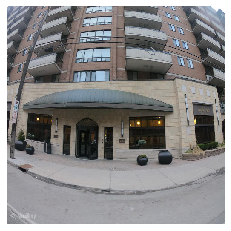

Albert at Bay Suite Hotel 435 Albert Street 0.png
This image of building entrance is 97.23 percent accessible and 2.77 percent inaccessible.
✅ - This image has been correctly classified as accessible.



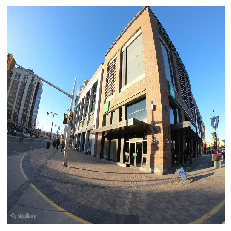

0009 A8-IT0RqrOz9YlybO7_UEg.png
This image of building entrance is 99.40 percent accessible and 0.60 percent inaccessible.
✅ - This image has been correctly classified as accessible.



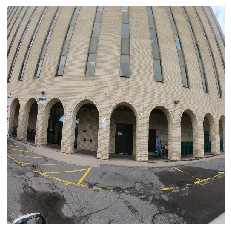

Billings Bridge Shopping Centre 2277 Riverside Drive 63.png
This image of building entrance is 14.93 percent accessible and 85.07 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



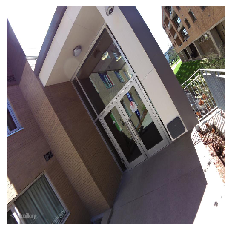

Glengarry House 1125 Colonel By Drive 37.png
This image of building entrance is 2.17 percent accessible and 97.83 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



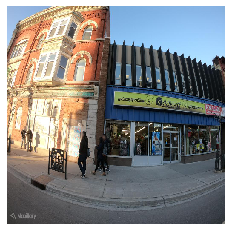

0568 5gjKjaLu72fZulzYn6dakA.png
This image of building entrance is 98.50 percent accessible and 1.50 percent inaccessible.
✅ - This image has been correctly classified as accessible.



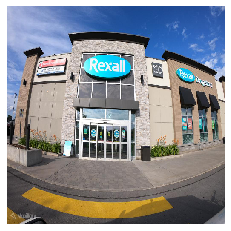

Staples 1595 Merivale Road 68.png
This image of building entrance is 99.70 percent accessible and 0.30 percent inaccessible.
✅ - This image has been correctly classified as accessible.



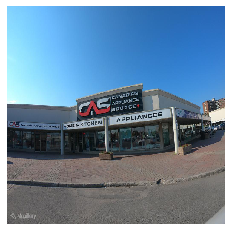

Ottawa Public Library - Emerald Plaza Branch 1547 Merivale Road 4.png
This image of building entrance is 99.29 percent accessible and 0.71 percent inaccessible.
✅ - This image has been correctly classified as accessible.



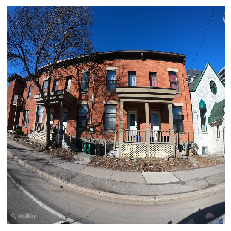

Meta Esthétique 250 A Lyon Street North 3.png
This image of building entrance is 61.31 percent accessible and 38.69 percent inaccessible.
❌ - This image has been incorrectly classified as accessible.



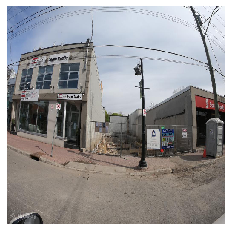

Scotiabank 388 Richmond Road 11.png
This image of building entrance is 97.29 percent accessible and 2.71 percent inaccessible.
❌ - This image has been incorrectly classified as accessible.



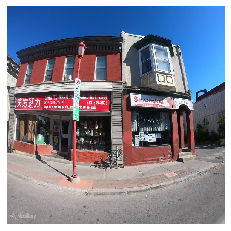

0096 olMK38JhuePHS_vVPQrYkw.png
This image of building entrance is 26.44 percent accessible and 73.56 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



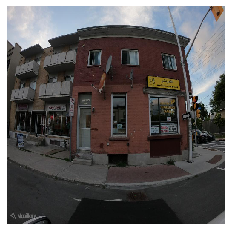

0077 X8w1Xk4VrfMbOqCxztCi3w.png
This image of building entrance is 0.20 percent accessible and 99.80 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



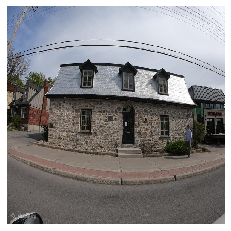

0042 kgZ8UZmcHMX6iYWQb05jcA.png
This image of building entrance is 1.24 percent accessible and 98.76 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



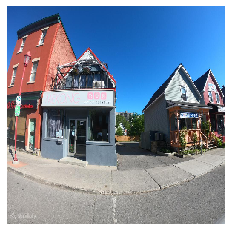

0087 xqF3ROA1jI2Z-7cSkyLxCQ.png
This image of building entrance is 7.41 percent accessible and 92.59 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



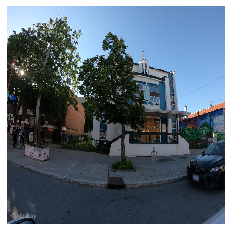

725 Somerset Street West 10.png
This image of building entrance is 44.34 percent accessible and 55.66 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



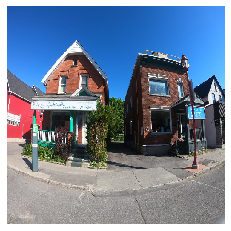

Jadeland Restaurant 625 Somerset Street West 0.png
This image of building entrance is 0.62 percent accessible and 99.38 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



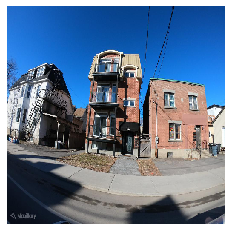

474 Lyon Street North 2.png
This image of building entrance is 6.52 percent accessible and 93.48 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



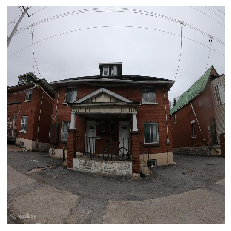

465 Catherine Street 13.png
This image of building entrance is 0.35 percent accessible and 99.65 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.

7 of the 10 accessible images were correctly classified as accessible.
8 of the 10 inaccessible images were correctly classified as inaccessible.


In [ ]:
import os

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/'
correctInaccessible = 0
correctAccessible = 0

for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage),target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score < 0.5):
            print("✅ - This image has been correctly classified as accessible.\n")
            correctAccessible += 1
        elif (score== 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as inaccessible.\n")

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible/'
for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage), 
                                                 target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score > 0.5):
            print("✅ - This image has been correctly classified as inaccessible.\n")
            correctInaccessible += 1
        elif (score == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as accessible.\n")

print("%i of the 10 accessible images were correctly classified as accessible." % correctAccessible)
print("%i of the 10 inaccessible images were correctly classified as inaccessible." % correctInaccessible)
